In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import copy
import cv2
import time
from tqdm import tqdm

import matplotlib.pyplot as plt

import IPython
from IPython.display import Image as img
from IPython.display import display

from PIL import Image

import torch
import torch.nn as nn
import torchvision

/home/evivoli/miniconda3/envs/groundingdino/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from modules.DASS_Det_Inference.dass_det.models.yolox import YOLOX
from modules.DASS_Det_Inference.dass_det.models.yolo_head import YOLOXHead
from modules.DASS_Det_Inference.dass_det.models.yolo_head_stem import YOLOXHeadStem
from modules.DASS_Det_Inference.dass_det.models.yolo_pafpn import YOLOPAFPN

from modules.DASS_Det_Inference.dass_det.data.data_augment import ValTransform

from modules.DASS_Det_Inference.dass_det.evaluators.comic_evaluator import ComicEvaluator

from modules.DASS_Det_Inference.dass_det.utils import (
    postprocess,
    xyxy2xywh,
    vis
)

## Set the Parameters Below

In [11]:
model_path  = "../../benchmarks/weights/xl_dcm_finetuned_stage3.pth" # None # "weights/..."
model_size  = "xl" # "xs"
model_mode  = 0    # 1 for only face, 2 for only body

nms_thold   = 0.4
conf_thold  = 0.65
resize_size = (1024, 1024)

image_path  = "../../data/datasets/comics/data/raw_page_images/3665/012.jpg"

In [12]:
transform = ValTransform()

def predict_and_draw(model, imgs, path, scale, sizes, conf_thold, nms_thold):
    img_cu = torch.Tensor(imgs).unsqueeze(0).cuda()
    # print("Predicting:", path)
    
    with torch.no_grad():
        face_preds, body_preds = model(img_cu, mode=0)
        face_preds = postprocess(face_preds, 1, conf_thold, nms_thold)[0]
        body_preds = postprocess(body_preds, 1, conf_thold, nms_thold)[0]

    del img_cu
    
    if face_preds is not None: 
        len_faces = face_preds.shape[0]
    else:
        len_faces = 0
    
    if body_preds is not None:
        len_bodies = body_preds.shape[0]
    else:
        len_bodies = 0
    
    if face_preds is not None and body_preds is not None:
        preds = torch.cat([face_preds, body_preds], dim=0)
    elif face_preds is not None:
        preds = face_preds
    elif body_preds is not None:
        preds = body_preds
    else:
        print("No faces or bodies are found!")
        if type(path) == str:
            p_img = cv2.imread(path)[:,:,::-1]
        else:
            p_img = cv2.imread(os.path.join(path[1], path[2] + ".jpg"))[:,:,::-1]
        plt.imshow(p_img)
        return

    classes = torch.cat([torch.zeros(len_faces), torch.ones(len_bodies)])

    preds[:,:4] /= scale
    preds[:,0]  = torch.max(preds[:,0], torch.zeros(preds.shape[0]).cuda())
    preds[:,1]  = torch.max(preds[:,1], torch.zeros(preds.shape[0]).cuda())
    preds[:,2]  = torch.min(preds[:,2], torch.zeros(preds.shape[0]).fill_(sizes[1]).cuda())
    preds[:,3]  = torch.min(preds[:,3], torch.zeros(preds.shape[0]).fill_(sizes[0]).cuda())
    scores      = preds[:,4]

    if type(path) == str:
        p_img = cv2.imread(path)[:,:,::-1]
    else:
        p_img = cv2.imread(os.path.join(path[1], path[2] + ".jpg"))[:,:,::-1]
    
    display(Image.fromarray(vis(copy.deepcopy(p_img), preds[:,:4], scores, classes, conf=0.0, class_names=["Face", "Body"])))
    
    del face_preds, body_preds, preds

## Load Model

In [13]:
assert model_path is not None
assert model_size in ["xs", "xl"]
assert model_mode in [0, 1, 2]

if model_size == "xs":
    depth, width = 0.33, 0.375
elif model_size == "xl":
    depth, width = 1.33, 1.25

model = YOLOX(backbone=YOLOPAFPN(depth=depth, width=width),
              head_stem=YOLOXHeadStem(width=width),
              face_head=YOLOXHead(1, width=width),
              body_head=YOLOXHead(1, width=width))

d = torch.load(model_path, map_location=torch.device('cpu'))

if "teacher_model" in d.keys():
    model.load_state_dict(d["teacher_model"])
else:
    model.load_state_dict(d["model"])
model = model.eval().cuda()

del d

## Predict Image

/home/evivoli/miniconda3/envs/groundingdino/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025829503/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


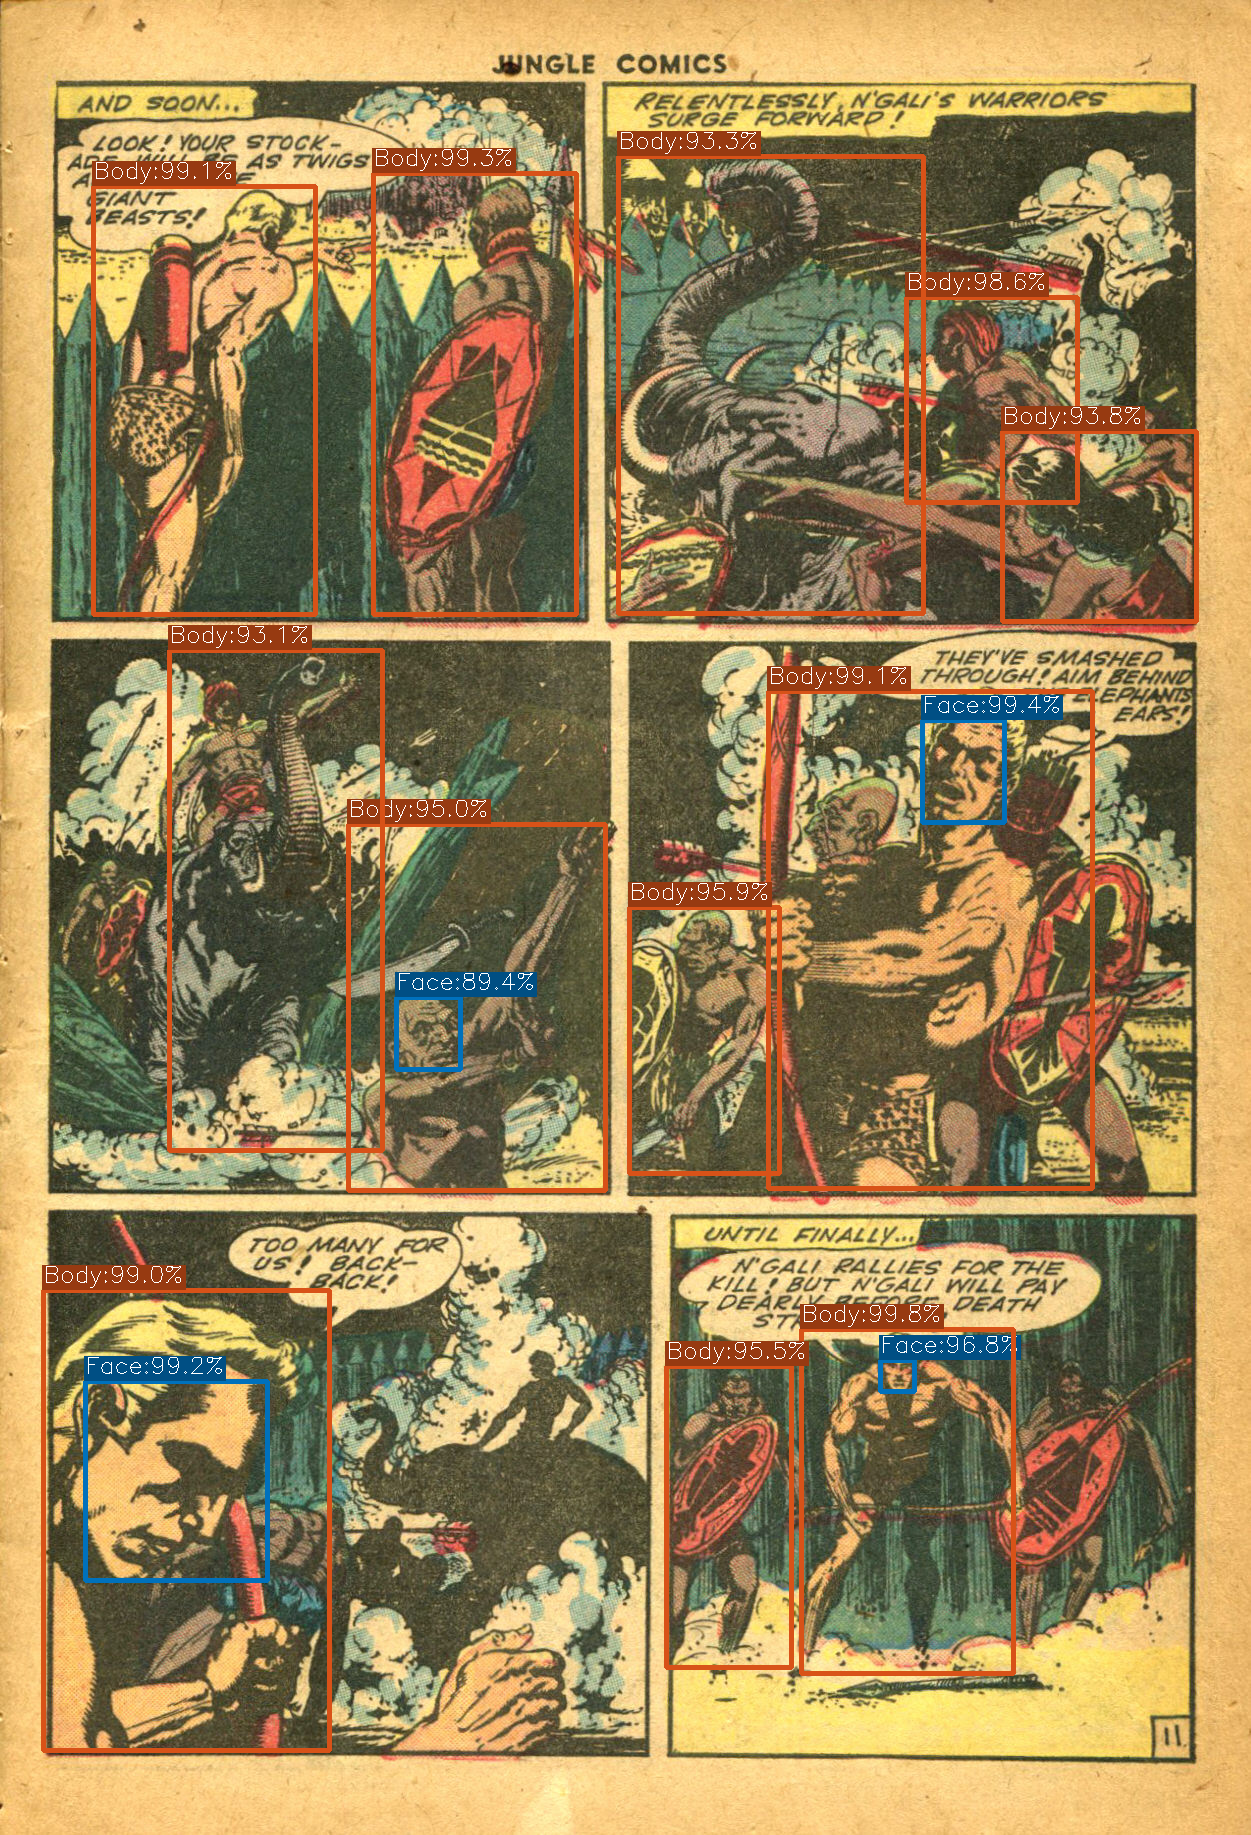

In [14]:
imgs = cv2.imread(image_path)
h, w, c = imgs.shape

imgs, labels = transform(imgs, None, resize_size)
scale = min(resize_size[0] / h, resize_size[1] / w)

predict_and_draw(model, copy.deepcopy(imgs), image_path, scale, [h, w], conf_thold, nms_thold)